In [1]:
!nvidia-smi

Wed Aug  7 06:02:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from pathlib import Path
from fastai.callbacks import *
from fastai.vision import *

In [3]:
path = Path('/kaggle/input/mri_dataset/MRI_Dataset/')
fnames = get_image_files(path / 'image')
lbl_names = get_image_files(path / 'label')

/kaggle/input/mri_dataset/MRI_Dataset/image/TCGA_DU_7306_19930512_25.tif


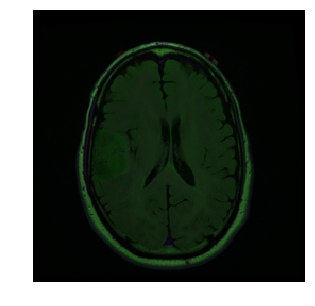

In [4]:
img_f = fnames[1100]

# 输出当前图像的路径
print(img_f)

# 读取图像
img = open_image(img_f)
img.show(figsize=(5, 5))

In [5]:
get_y_fn = lambda x : path / 'label' / f'{x.stem}_mask{x.suffix}'
print(get_y_fn(img_f))

/kaggle/input/mri_dataset/MRI_Dataset/label/TCGA_DU_7306_19930512_25_mask.tif


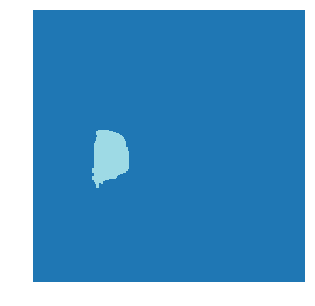

In [6]:
mask = open_mask(get_y_fn(img_f), div=True)
mask.show(figsize=(5, 5), alpha=1)

In [7]:
src_size = np.array(mask.shape[1:])
size = src_size # 图像尺寸 (256, 256)
bs = 16     # batch size

class MySegmentationLabelList(SegmentationLabelList):
    def open(self, fn):
        return open_mask(fn, div=True)

class MySegmentationItemList(SegmentationItemList):
    _label_cls, _square_show_res = MySegmentationLabelList, False

data = (MySegmentationItemList
        .from_folder(path / 'image')
        .split_by_rand_pct(0.2)
        .label_from_func(get_y_fn, classes=['0', '1'])
        .transform(get_transforms(), tfm_y=True, size=size)
        .databunch(bs=bs, path='/kaggle')
        .normalize(imagenet_stats))

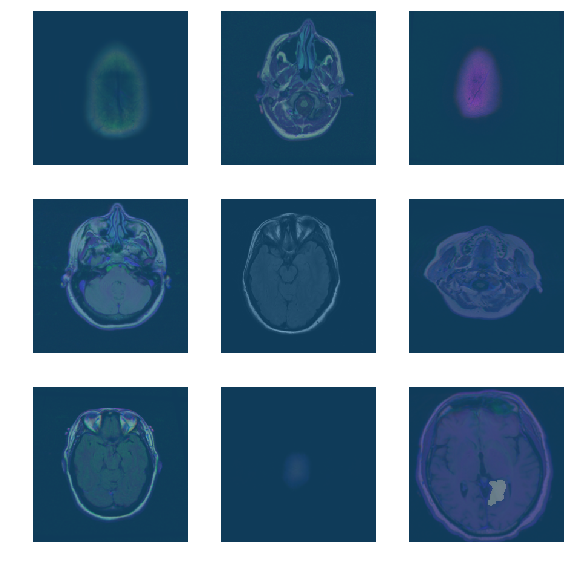

In [8]:
data.show_batch(3, figsize=(8, 8), alpha=0.5)

In [9]:
learn = unet_learner(data, models.resnet34, self_attention=True, metrics=dice, wd=1e-2).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 105209254.57it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


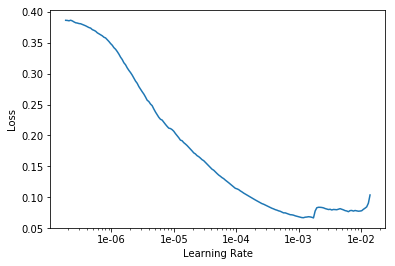

In [10]:
learn.lr_find(num_it=300)
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, slice(1e-05, 1e-03), pct_start=0.6,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='model')])

epoch,train_loss,valid_loss,dice,time
0,0.027243,0.026207,0.396491,01:47
1,0.644600,0.028729,0.405575,01:45
2,0.101116,0.029025,0.345800,01:44
3,0.169063,0.031065,0.001274,01:44
4,0.038727,0.026547,0.064408,01:44


Better model found at epoch 0 with valid_loss value: 0.02620718441903591.


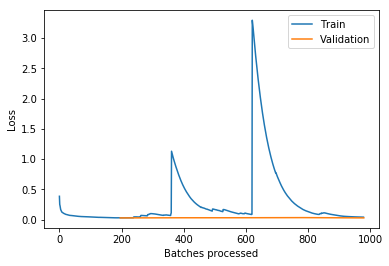

In [12]:
learn.recorder.plot_losses()

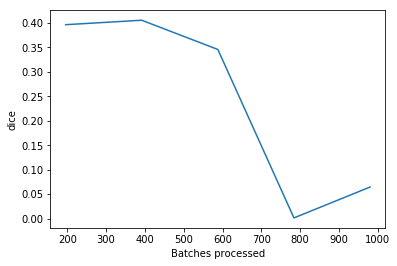

In [13]:
learn.recorder.plot_metrics()

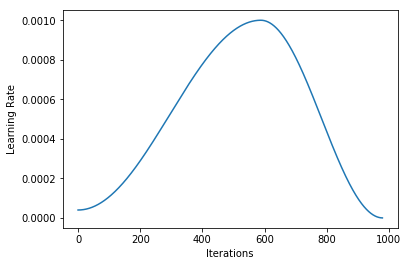

In [14]:
learn.recorder.plot_lr()

In [15]:
learn.load('model')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


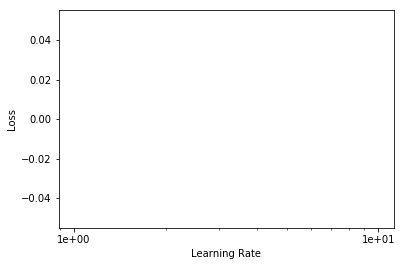

In [16]:
learn.lr_find(start_lr=1e-9, end_lr=1e-4, num_it=200)
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, slice(7e-07, 4e-06), pct_start=0.7,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='model')])

epoch,train_loss,valid_loss,dice,time
0,0.022076,0.017569,0.645748,01:50
1,0.018504,0.014436,0.747173,01:50
2,0.015392,0.012115,0.758336,01:50
3,0.013491,0.010507,0.778252,01:50
4,0.011977,0.010012,0.780738,01:50


Better model found at epoch 0 with valid_loss value: 0.017569057643413544.
Better model found at epoch 1 with valid_loss value: 0.014435648918151855.
Better model found at epoch 2 with valid_loss value: 0.01211472973227501.
Better model found at epoch 3 with valid_loss value: 0.010506994090974331.
Better model found at epoch 4 with valid_loss value: 0.010012471117079258.


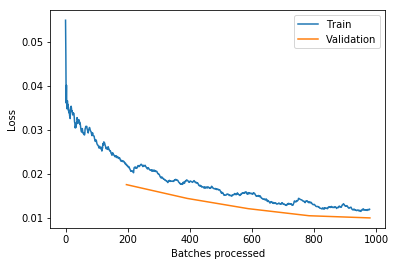

In [18]:
learn.recorder.plot_losses()

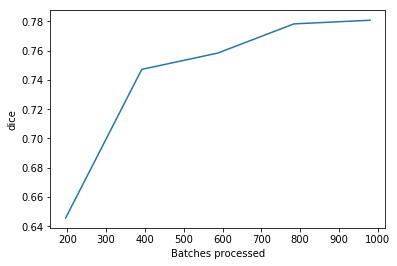

In [19]:
learn.recorder.plot_metrics()

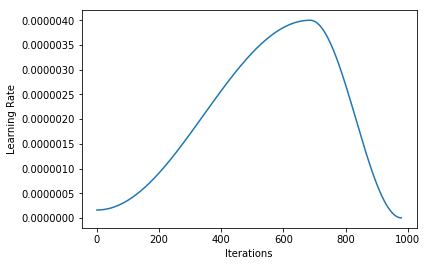

In [20]:
learn.recorder.plot_lr()

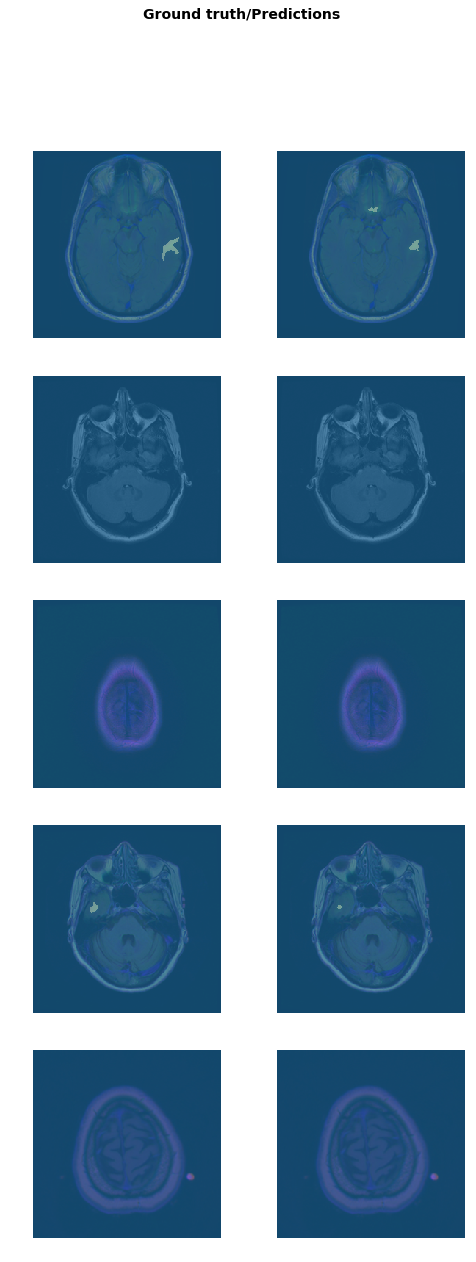

In [21]:
learn.show_results(alpha=0.6)